In [52]:
import datasets as k
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
import statsmodels.formula.api as sm
import xgboost as xgb
import os
from scipy import stats
import random
random.seed(100)

# Treatment group

In [53]:
x,y,e = k.q4()
data = pd.concat([x,e], axis=0)

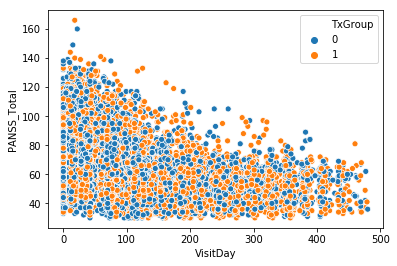

In [54]:
sns.scatterplot("VisitDay", "PANSS_Total", data=data, hue="TxGroup")

## APPROACH 1
**Calculating significance relative to rate of change**

In [2]:
DataSet_A = pd.read_csv("Study_A.csv")
DataSet_B = pd.read_csv("Study_B.csv")
DataSet_C = pd.read_csv("Study_C.csv")
DataSet_D = pd.read_csv("Study_D.csv")
DataSet_E = pd.read_csv("Study_E.csv")

DataSet_E["LeadStatus"] = None
DataSet_All = pd.concat([DataSet_A, DataSet_B, DataSet_C, DataSet_D, DataSet_E])

In [3]:
DataSet_All["POSS"] = DataSet_All.iloc[:, 8:15].sum(axis=1)
DataSet_All["NEGG"] = DataSet_All.iloc[:, 15:22].sum(axis=1)
DataSet_All["GENR"] = DataSet_All.iloc[:, 22:38].sum(axis=1)
DataSet_All["COMP"] = DataSet_All["POSS"] - DataSet_All["NEGG"]

DataSet_All_Long = DataSet_All[DataSet_All["VisitDay"]>=90]
DataSet_All_Short = DataSet_All[DataSet_All["VisitDay"]<90]

In [4]:
def find_diff(DataSet, obser_t):
    patient_id = DataSet.iloc[0]["PatientID"]
    last_obser = None
    last_day = None
    change_array = {"Control":[], "Treatment":[]}
    
    for i in range(DataSet.shape[0]):
        if last_obser == None:
            last_obser = DataSet.iloc[i][obser_t]
            last_day = DataSet.iloc[i]["VisitDay"]
            patient_id = DataSet.iloc[i]["PatientID"]           
        elif patient_id == DataSet.iloc[i]["PatientID"]:
             #print((DataSet.iloc[i]["VisitDay"] - last_day) / float(last_obser - DataSet.iloc[i][obser_t]))
            if (DataSet.iloc[i]["VisitDay"] != last_day):
                change_array[DataSet.iloc[i]["TxGroup"]] += [float(last_obser - DataSet.iloc[i][obser_t]) / (DataSet.iloc[i]["VisitDay"] - last_day)]
            last_obser = DataSet.iloc[i][obser_t]
            last_day = DataSet.iloc[i]["VisitDay"]         
        else:
            last_obser = DataSet.iloc[i][obser_t]
            patient_id = DataSet.iloc[i]["PatientID"]
            last_day = DataSet.iloc[i]["VisitDay"]
    change_array["Control"] = np.array(change_array["Control"])
    change_array["Treatment"] = np.array(change_array["Treatment"])        
    return change_array

In [5]:
def SimpleMeanMovementPTesting(DataSet):
    ChangeDict_All = find_diff(DataSet, "PANSS_Total")
    print("PANSS_Total")
    print("MEAN:")
    print((ChangeDict_All["Treatment"]).mean(), (ChangeDict_All["Control"]).mean())
    print("T-TEST:")
    print(stats.ttest_ind(ChangeDict_All["Treatment"],ChangeDict_All["Control"]))
    ChangeDict_All = find_diff(DataSet, "POSS")
    print("POSS")
    print("MEAN:")
    print((ChangeDict_All["Treatment"]).mean(), (ChangeDict_All["Control"]).mean())
    print("T-TEST:")
    print(stats.ttest_ind(ChangeDict_All["Treatment"],ChangeDict_All["Control"]))
    ChangeDict_All = find_diff(DataSet, "NEGG")
    print("NEGG")
    print("MEAN:")
    print((ChangeDict_All["Treatment"]).mean(), (ChangeDict_All["Control"]).mean())
    print("T-TEST:")
    print(stats.ttest_ind(ChangeDict_All["Treatment"],ChangeDict_All["Control"]))
    ChangeDict_All = find_diff(DataSet, "GENR")
    print("GENR")
    print("MEAN:")
    print((ChangeDict_All["Treatment"]).mean(), (ChangeDict_All["Control"]).mean())
    print("T-TEST:")
    print(stats.ttest_ind(ChangeDict_All["Treatment"],ChangeDict_All["Control"]))
    ChangeDict_All = find_diff(DataSet, "COMP")
    print("COMP")
    print("MEAN:")
    print((ChangeDict_All["Treatment"]).mean(), (ChangeDict_All["Control"]).mean())
    print("T-TEST:")
    print(stats.ttest_ind(ChangeDict_All["Treatment"],ChangeDict_All["Control"]))
    return True

In [6]:
# Over 90 days
SimpleMeanMovementPTesting(DataSet_All_Long)

PANSS_Total
MEAN:
0.04698912664863048 0.03468947900246608
T-TEST:
Ttest_indResult(statistic=0.5556970399644168, pvalue=0.578434573610372)
POSS
MEAN:
0.010783449584150633 0.0038102687531378367
T-TEST:
Ttest_indResult(statistic=0.9986511311772542, pvalue=0.3179959741926303)
NEGG
MEAN:
0.009086992525855146 0.013058404659184522
T-TEST:
Ttest_indResult(statistic=-0.7034601700247184, pvalue=0.48179088039116325)
GENR
MEAN:
0.027118684538624697 0.017820805590143714
T-TEST:
Ttest_indResult(statistic=0.7448619629841454, pvalue=0.4563785358008079)
COMP
MEAN:
0.0016964570582954858 -0.009248135906046687
T-TEST:
Ttest_indResult(statistic=1.641321923422913, pvalue=0.10077258139365106)


True

In [7]:
# Less than 90 days
SimpleMeanMovementPTesting(DataSet_All_Short)

PANSS_Total
MEAN:
0.32361296460178696 0.3401329834564672
T-TEST:
Ttest_indResult(statistic=-0.8324841102001396, pvalue=0.405154859140086)
POSS
MEAN:
0.11156039466269299 0.11607997481604225
T-TEST:
Ttest_indResult(statistic=-0.6343324893369096, pvalue=0.52587781007945)
NEGG
MEAN:
0.0590583162391867 0.06134845586714292
T-TEST:
Ttest_indResult(statistic=-0.3774516324802083, pvalue=0.7058457044238515)
GENR
MEAN:
0.15299425369990727 0.16270455277328205
T-TEST:
Ttest_indResult(statistic=-0.8787065959620642, pvalue=0.37958068205514783)
COMP
MEAN:
0.052502078423506286 0.05473151894889932
T-TEST:
Ttest_indResult(statistic=-0.2902940297659159, pvalue=0.7715970937135274)


True

In [8]:
# All Data
SimpleMeanMovementPTesting(DataSet_All)

PANSS_Total
MEAN:
0.1984569855142746 0.2034089176277427
T-TEST:
Ttest_indResult(statistic=-0.3631195063185887, pvalue=0.7165195091840634)
POSS
MEAN:
0.0652193851683668 0.06595045992280872
T-TEST:
Ttest_indResult(statistic=-0.15619442602055378, pvalue=0.8758813704290924)
NEGG
MEAN:
0.0371588547290111 0.03945087836761666
T-TEST:
Ttest_indResult(statistic=-0.5890565256271992, pvalue=0.5558301089383373)
GENR
MEAN:
0.0960787456168967 0.0980075793373173
T-TEST:
Ttest_indResult(statistic=-0.25341848159178404, pvalue=0.7999474914807111)
COMP
MEAN:
0.028060530439355694 0.026499581555192053
T-TEST:
Ttest_indResult(statistic=0.3234235996002911, pvalue=0.7463778917087067)


True

There is no significance

## APPROACH 2

### Regression with variables TxGroup and Visit Day ~ PANSS Total

In [55]:
cols = ["TxGroup",'VisitDay']
datax = data[cols]
datay = data["PANSS_Total"]

In [56]:
#Normalizing data
datax =(datax-datax.mean())/datax.std()
results = sm.OLS(datay, datax).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            PANSS_Total   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     256.5
Date:                Wed, 14 Aug 2019   Prob (F-statistic):          6.67e-111
Time:                        22:00:05   Log-Likelihood:            -1.3073e+05
No. Observations:               22909   AIC:                         2.615e+05
Df Residuals:                   22907   BIC:                         2.615e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TxGroup        0.0852      0.481      0.177      0.8

In [35]:
cols = ["TxGroup",'VisitDay', 'Country_Mean', 'Rater_Mean', 'Site_Mean']
datax = data[cols]
datay = data["PANSS_Total"]
#Normalizing data
datax =(datax-datax.mean())/datax.std()
results = sm.OLS(datay, datax).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            PANSS_Total   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     169.2
Date:                Tue, 13 Aug 2019   Prob (F-statistic):          2.23e-177
Time:                        17:54:51   Log-Likelihood:            -1.3056e+05
No. Observations:               22909   AIC:                         2.611e+05
Df Residuals:                   22904   BIC:                         2.612e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
TxGroup          0.2600      0.478      0.544   

# Regression with interaction variables and predicting each score

In [39]:
cols = ["TxGroup",'VisitDay', 'Country_Mean', 'Rater_Mean', 'Site_Mean']
datax = data[cols]
scores =['P5', 'N6', 'G3', 'G5']

In [40]:
#Normalizing data
datax =(datax-datax.mean())/datax.std()
for i in scores:    
    results = sm.OLS(data[i], datax).fit()
    print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     P5   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     299.0
Date:                Tue, 13 Aug 2019   Prob (F-statistic):          4.30e-311
Time:                        20:35:05   Log-Likelihood:                -49077.
No. Observations:               22909   AIC:                         9.816e+04
Df Residuals:                   22904   BIC:                         9.820e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
TxGroup         -0.0122      0.014     -0.893   

## APPROACH 3

In [36]:
cols = ["TxGroup",'VisitDay', 'Country_Mean', 'Rater_Mean', 'Site_Mean']
datax = data[cols]
datay = data["PANSS_Total"]

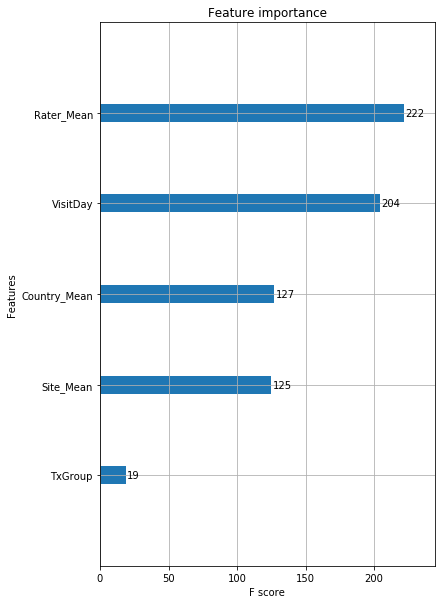

XGB score:  0.6577940049300155


In [37]:
x_train, x_test, y_train, y_test = train_test_split(datax, datay, test_size=0.20)
model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(x_train, y_train)
# plot feature importance
ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(6, 10)
pyplot.show()
predict = model.predict(x_test)
score = model.score(x_test, y_test)
print("XGB score: ", score)

In [38]:
print(model.feature_importances_)

[0.00435191 0.612076   0.06161607 0.2591266  0.06282942]
